### Readme
 - '군집최종data' 파일이 있어야 군집 결과가 csv파일로 저장됩니다.


1  :  0.5422291318000934
2  :  0.6700108555183173
3  :  0.7806681423714265
4  :  0.8704143162976471
5  :  0.9321929447210882
6  :  0.9601815669676358
7  :  0.9722174650903993
8  :  0.9818106067374051
9  :  0.989626785012949
10  :  0.9967092279583629
11  :  0.9999999999999999


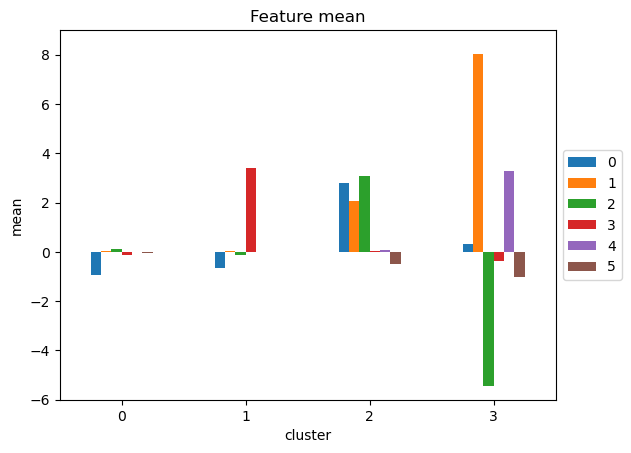

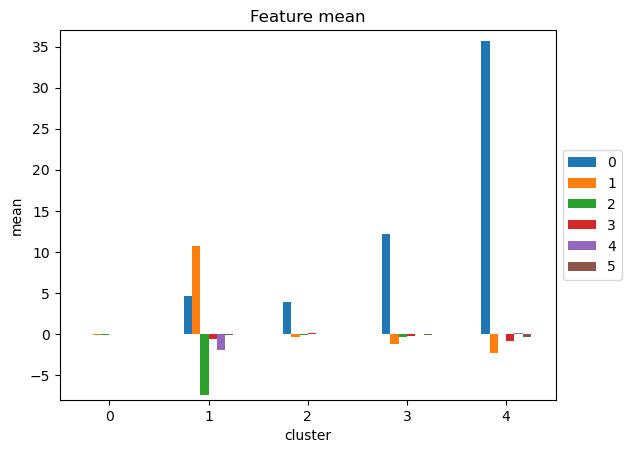

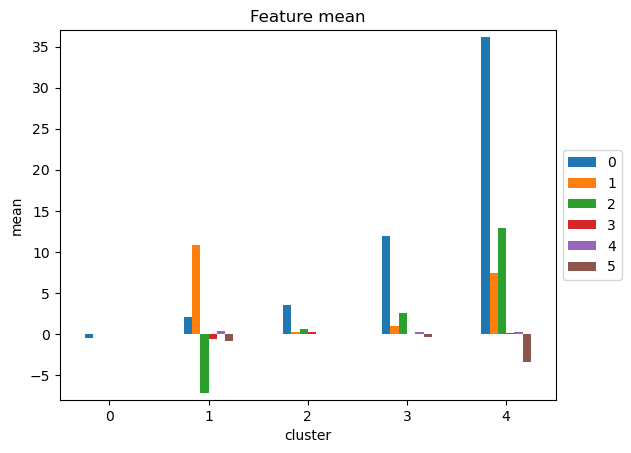

5     201657
9     125952
0     116878
11     34632
6       9204
12      6558
2       6513
7       2631
10      1241
8        708
13       607
3        560
1        545
4         29
Name: cluster, dtype: int64


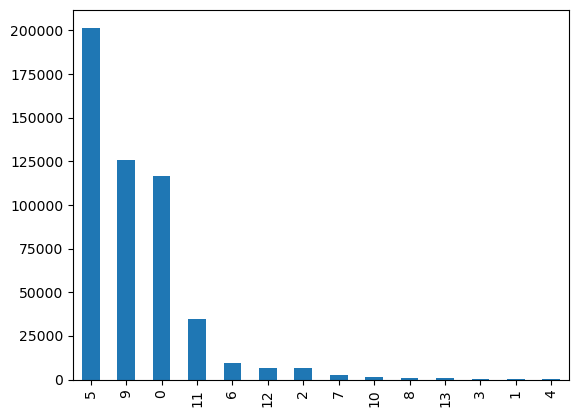

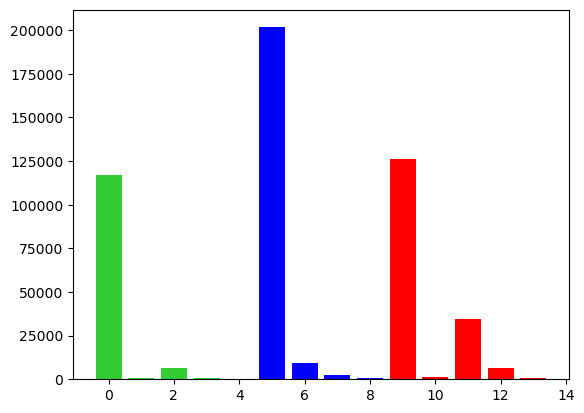

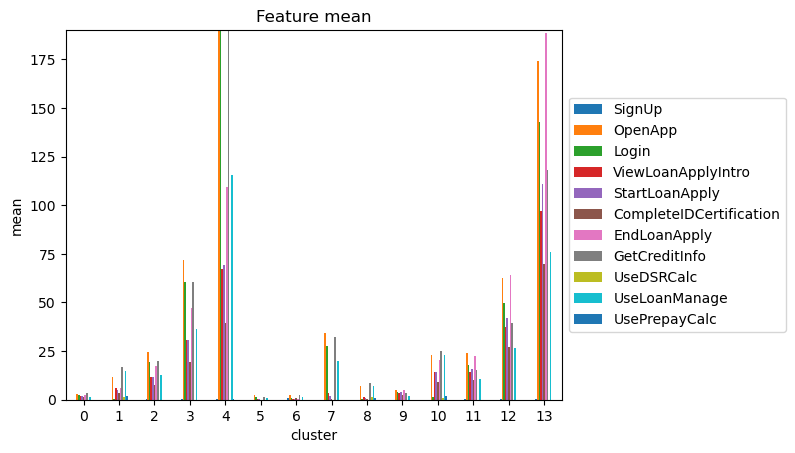

<Figure size 3000x4000 with 0 Axes>

SignUp


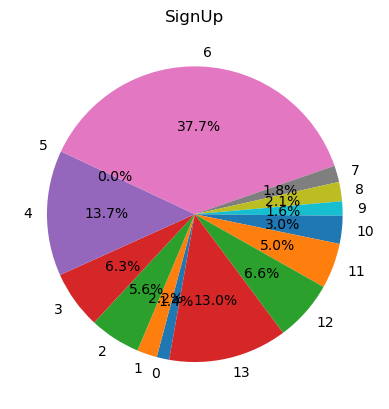

OpenApp


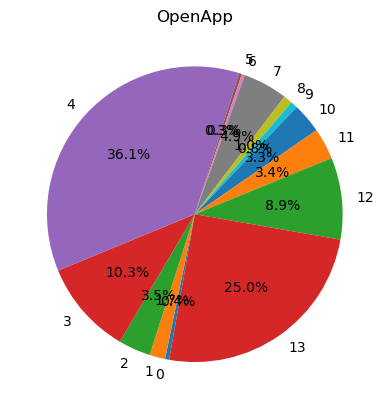

Login


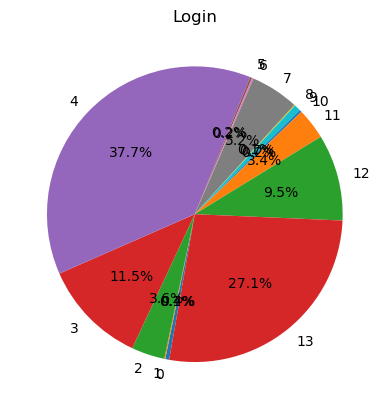

ViewLoanApplyIntro


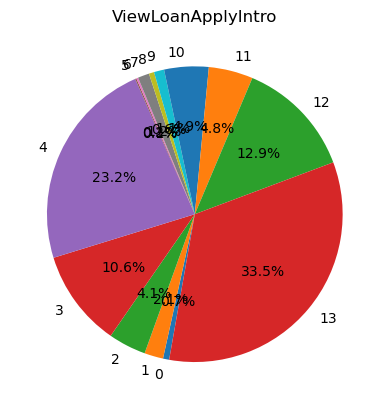

StartLoanApply


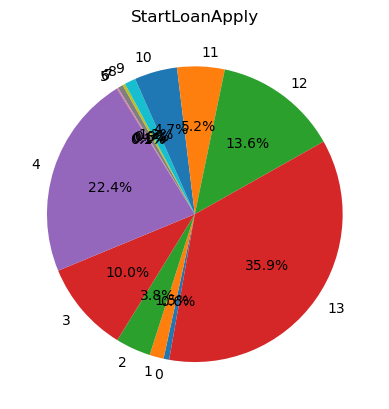

CompleteIDCertification


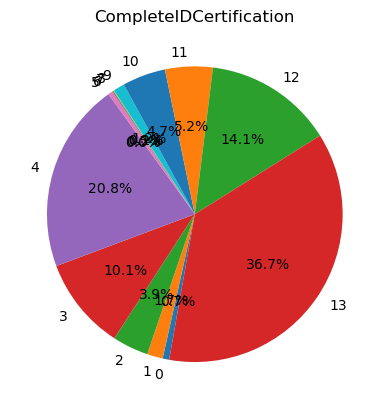

EndLoanApply


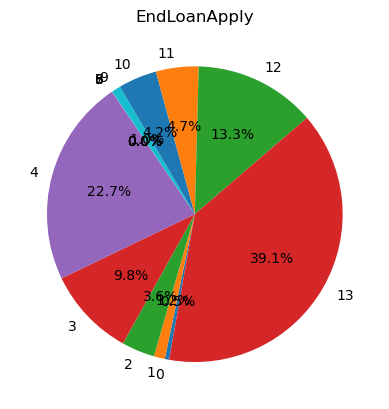

GetCreditInfo


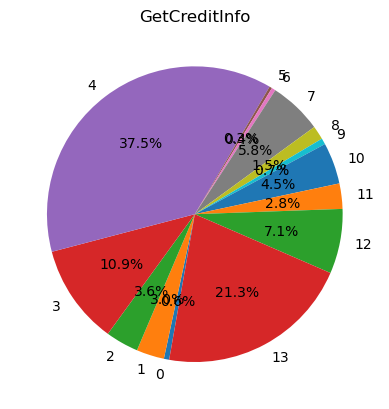

UseDSRCalc


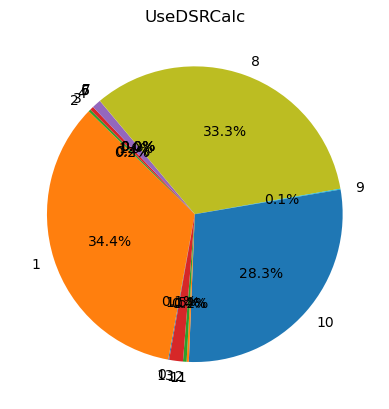

UseLoanManage


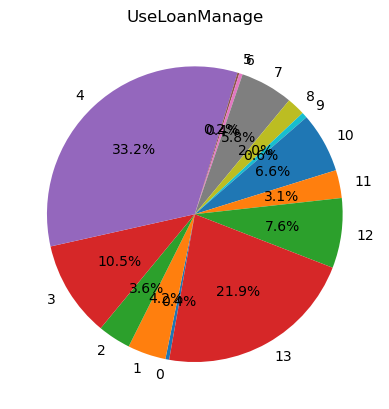

UsePrepayCalc


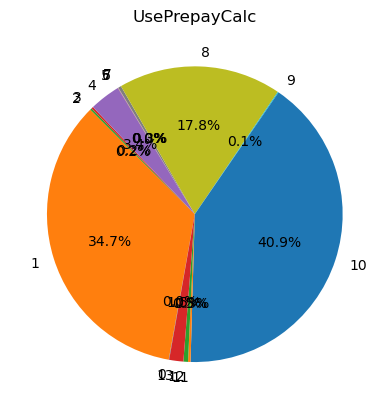

In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df = pd.read_csv('./raw_data/log_data.csv')
df = df.drop(columns=['timestamp','mp_os','mp_app_version','date_cd'])
df = pd.concat([df, pd.get_dummies(df['event'])], axis=1)
df = df.drop(columns=['event'])
df = df.groupby(['user_id']).sum()

scaler = StandardScaler()
scaler.fit(df)
dfscaled = scaler.transform(df)

newdata = pd.DataFrame(data = dfscaled, index = df.index, columns = df.columns)

pca = PCA()
pca.fit(newdata)

for i in range(1, 12):
    print(i, " : ", sum(pca.explained_variance_ratio_[:i]))

pca = PCA(n_components = 6)
pca.fit(newdata)

df_pca = pca.transform(newdata)
df_pca = pd.DataFrame(df_pca)

userid = newdata.index
df_pca['user_id'] = userid

all =pd.read_pickle('./tmp_data/imp_all.pkl')
group = all.groupby(['user_id']).sum()

zero = group[group['is_applied']==0].index.tolist()
notzero = group[group['is_applied']!=0].index.tolist()
df_pca_zero = df_pca[df_pca['user_id'].isin(zero)]
df_pca_notzero = df_pca[df_pca['user_id'].isin(notzero)]

userspec = pd.read_csv('./raw_data/user_spec.csv')
df_pca_notzero.to_csv('./tmp_data/notzero.csv')
df_pca_zero.to_csv('./tmp_data/zero.csv')
df['user_id'] = df.index.tolist()
userspecid = userspec['user_id'].tolist()
dfnew = df_pca[~df_pca['user_id'].isin(userspecid)]
dfnew.to_csv('./tmp_data/notinuserspec.csv')


user = pd.read_csv('./tmp_data/notinuserspec.csv')
result = user.drop(columns = ['Unnamed: 0','user_id'])

kmeans = KMeans(n_clusters=4)
kmeans.fit(result)

cluster = kmeans.predict(result)
result['target'] = cluster

df2 = result.groupby(['target']).mean()
df2.plot.bar(rot=0)
plt.title("Feature mean")
plt.xlabel("cluster")
plt.ylabel("mean")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-6, 9)
plt.show()

# not in userspec cluster result 저장
user = user.drop(columns=['Unnamed: 0'])
user['cluster'] = result.target.tolist()
user[['user_id', 'cluster']].to_csv('./tmp_data/notinuserspeccluster.csv')


user = pd.read_csv('./tmp_data/notzero.csv')

result = user.drop(columns = ['Unnamed: 0','user_id'])

kmeans = KMeans(n_clusters=5)
kmeans.fit(result)

cluster = kmeans.predict(result)
result['target'] = cluster
df2 = result.groupby(['target']).mean()
df2.plot.bar(rot=0)
plt.title("Feature mean")
plt.xlabel("cluster")
plt.ylabel("mean")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-8, 37)
plt.show()

# not zero cluster result 저장
user = user.drop(columns=['Unnamed: 0'])
user['cluster'] = result.target.tolist()
user[['user_id', 'cluster']].to_csv('./tmp_data/notzerocluster.csv')

user=pd.read_csv('./tmp_data/zero.csv')
result=user.drop(columns = ['Unnamed: 0','user_id'])
Kmean = KMeans(n_clusters=5)
Kmean.fit(result)
cluster = kmeans.predict(result)
result['target'] = cluster
df2 = result.groupby(['target']).mean()
df2.plot.bar(rot=0)
plt.title("Feature mean")
plt.xlabel("cluster")
plt.ylabel("mean")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-8, 37)
plt.show()

# zero result 저장
user = user.drop(columns=['Unnamed: 0'])
user['cluster'] = result.target.tolist()
user[['user_id', 'cluster']].to_csv('./tmp_data/zerocluster.csv')


zero = pd.read_csv('./tmp_data/zerocluster.csv', index_col=0)
notinuserspec = pd.read_csv('./tmp_data/notinuserspeccluster.csv', index_col=0)
notzero = pd.read_csv('./tmp_data/notzerocluster.csv', index_col=0)

notinuserspec['cluster'] = notinuserspec['cluster'] + 5
notzero['cluster'] = notzero['cluster'] + 9



pd.concat([zero, notzero,notinuserspec]).to_csv('./tmp_data/withlabel1.csv')

df = pd.read_csv('./tmp_data/withlabel1.csv', index_col=0)
log = pd.read_csv('./raw_data/log_data.csv')
log = log.drop(columns=['timestamp', 'mp_os', 'mp_app_version', 'date_cd'])
log = pd.concat([log,pd.get_dummies(log['event'])], axis=1)
log = log.drop(columns=['event'])
pd.merge(log.groupby(by=['user_id']).sum(), df, on='user_id').to_csv('./군집최종data/final_clustering.csv')

df = pd.read_csv('./군집최종data/final_clustering.csv', index_col=0)
df = df.drop(columns = 'user_id')
result =df.groupby(['cluster']).mean()
cluster_size = df['cluster'].value_counts()
print(cluster_size)
cluster_size.plot(kind='bar')
plt.show()

cluster_size_df = pd.DataFrame(cluster_size)
x1 = [i for i in range(5)]
y1 = [cluster_size_df.loc[i].cluster for i in range(5)]
plt.bar(x1,y1, color='limegreen')

x2 = [i for i in range(5,9)]
y2 = [cluster_size_df.loc[i].cluster for i in range(5,9)]
plt.bar(x2,y2, color='blue')

x3 = [i for i in range(9,14)]
y3 = [cluster_size_df.loc[i].cluster for i in range(9,14)]
plt.bar(x3,y3, color='red')

plt.show()

result = result[['SignUp','OpenApp','Login','ViewLoanApplyIntro','StartLoanApply','CompleteIDCertification', 'EndLoanApply',
                'GetCreditInfo','UseDSRCalc', 'UseLoanManage','UsePrepayCalc']]

result.plot.bar(rot=0)
plt.title("Feature mean")
plt.xlabel("cluster")
plt.ylabel("mean")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 190)
plt.figure(figsize=(30,40))
plt.show()

labels = [i for i in range(14)]
for i in result.columns:
    print(i)
    ratio = result[i]
    plt.title(i)
    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)
    plt.show()

In [3]:
df = pd.read_csv('./군집최종data/final_clustering.csv', index_col=0)

In [4]:
df_1 = df[df['cluster']<=4]
df_2 = df[(df['cluster']>4)&(df['cluster']<=8)]
df_3 = df[(df['cluster']>8)&(df['cluster']<=13)]

In [5]:
df_1_mean = df_1.groupby('cluster').mean()
df_2_mean = df_2.groupby('cluster').mean()
df_3_mean = df_3.groupby('cluster').mean()

In [6]:
df_1_mean = df_1_mean.drop(columns=['user_id'])
df_2_mean = df_2_mean.drop(columns=['user_id'])
df_3_mean = df_3_mean.drop(columns=['user_id'])

In [7]:
sum_1 = df_1_mean.sum()
sum_2 = df_2_mean.sum()
sum_3 = df_3_mean.sum()

In [8]:
df_1_mean['CompleteIDCertification'] = df_1_mean['CompleteIDCertification'] / sum_1[0]
df_1_mean['EndLoanApply'] = df_1_mean['EndLoanApply'] / sum_1[1]
df_1_mean['GetCreditInfo'] = df_1_mean['GetCreditInfo'] / sum_1[2]
df_1_mean['Login'] = df_1_mean['Login'] / sum_1[3]
df_1_mean['OpenApp'] = df_1_mean['OpenApp'] / sum_1[4]
df_1_mean['SignUp'] = df_1_mean['SignUp'] / sum_1[5]
df_1_mean['StartLoanApply'] = df_1_mean['StartLoanApply'] / sum_1[6]
df_1_mean['UseDSRCalc'] = df_1_mean['UseDSRCalc'] / sum_1[7]
df_1_mean['UseLoanManage'] = df_1_mean['UseLoanManage'] / sum_1[8]
df_1_mean['UsePrepayCalc'] = df_1_mean['UsePrepayCalc'] / sum_1[9]
df_1_mean['ViewLoanApplyIntro'] = df_1_mean['ViewLoanApplyIntro'] / sum_1[10]

In [9]:
df_2_mean['CompleteIDCertification'] = df_2_mean['CompleteIDCertification'] / sum_2[0]
df_2_mean['EndLoanApply'] = df_2_mean['EndLoanApply'] / sum_2[1]
df_2_mean['GetCreditInfo'] = df_2_mean['GetCreditInfo'] / sum_2[2]
df_2_mean['Login'] = df_2_mean['Login'] / sum_2[3]
df_2_mean['OpenApp'] = df_2_mean['OpenApp'] / sum_2[4]
df_2_mean['SignUp'] = df_2_mean['SignUp'] / sum_2[5]
df_2_mean['StartLoanApply'] = df_2_mean['StartLoanApply'] / sum_2[6]
df_2_mean['UseDSRCalc'] = df_2_mean['UseDSRCalc'] / sum_2[7]
df_2_mean['UseLoanManage'] = df_2_mean['UseLoanManage'] / sum_2[8]
df_2_mean['UsePrepayCalc'] = df_2_mean['UsePrepayCalc'] / sum_2[9]
df_2_mean['ViewLoanApplyIntro'] = df_2_mean['ViewLoanApplyIntro'] / sum_2[10]

In [10]:
df_3_mean['CompleteIDCertification'] = df_3_mean['CompleteIDCertification'] / sum_3[0]
df_3_mean['EndLoanApply'] = df_3_mean['EndLoanApply'] / sum_3[1]
df_3_mean['GetCreditInfo'] = df_3_mean['GetCreditInfo'] / sum_3[2]
df_3_mean['Login'] = df_3_mean['Login'] / sum_3[3]
df_3_mean['OpenApp'] = df_3_mean['OpenApp'] / sum_3[4]
df_3_mean['SignUp'] = df_3_mean['SignUp'] / sum_3[5]
df_3_mean['StartLoanApply'] = df_3_mean['StartLoanApply'] / sum_3[6]
df_3_mean['UseDSRCalc'] = df_3_mean['UseDSRCalc'] / sum_3[7]
df_3_mean['UseLoanManage'] = df_3_mean['UseLoanManage'] / sum_3[8]
df_3_mean['UsePrepayCalc'] = df_3_mean['UsePrepayCalc'] / sum_3[9]
df_3_mean['ViewLoanApplyIntro'] = df_3_mean['ViewLoanApplyIntro'] / sum_3[10]

In [11]:
df_1_mean.to_csv('./tmp_data/cluster1_info.csv')
df_2_mean.to_csv('./tmp_data/cluster2_info.csv')
df_3_mean.to_csv('./tmp_data/cluster3_info.csv')